# Mimicking Human Image Similarity Judgment Using Siamese Neural Network

  **By:** Bonnie, You, Bereket, Melika
  

# Introduction

Humans have the ability to make similarity judgments about objects. These judgments are formed through hierarchical categorization of core criterias of the objects such as color, shape, purpose, etc. Our project trains a neural network model that can capture the core dimensions used by humans to judge similarity between objects and apply it to recognizing the “odd one out” in a set of triplet natural images.

Our idea was motivated by a [NIH paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7666026/#R17) that showed human object similarity can be recreated through using embedding matrix with a modeling algorithm. In our implementation we hope to achieve the same objective but instead using a neural network.

#Objective

**Research Question:** Can we mimic human visual similarity judgment using a neural network that can learn representations from images used in odd-one-out tasks?

**Hypothesis:** We hypothesize that the neural network will perform to a level close to humans in identifying odd-out images and the learned representations will not be affected by noise and geometric variations introduced to the input images.

## Set Up

In [ ]:
# @title Import necessary libraries
import os
import cv2
import re
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import IPython.display as display
import librosa
import librosa.display
from PIL import Image
from __future__ import print_function
import argparse, random, copy
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Connect to your own google drive
from google.colab import drive
drive.mount('/content/drive')

# Add the shared folder to your own drive
# sharing link: https://drive.google.com/drive/folders/1x3tdfgPkzZ73JvPHsmwApbs_eIRMxgGe?usp=drive_link
%cd /content/drive/MyDrive/NMA_Project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1x3tdfgPkzZ73JvPHsmwApbs_eIRMxgGe/NMA_Project


## Download the Dataset

In [ ]:
# Download the dataset to Google Drive

import requests

def unzipdata(fname,dname,password):
  if fname.lower().endswith('.zip'):
    if password:
      !unzip -P {password} {fname} -d {dname} > /dev/null 2>&1
    else:
      !unzip {fname} -d {dname} > /dev/null 2>&1
    print("Successfully unzip {} !".format(fname))
  else:
    !mv {fname} {dname}


def downloaddata(fname,url):
  '''
  fname: filename of the data to be downloaded
  url: URL for the data
  '''
  try:
    # sends a GET request
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download {} !!!".format(fname))
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download {} !!!".format(fname))
    else:
      # download the file
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print("Successfully downloaded {} !".format(fname))


fnames = ["full_triplet_dataset.zip","sortind.mat","unique_id.txt",
          "object_images_A-C.zip","object_images_D-K.zip""object_images_L-Q.zip","object_images_R-S.zip","object_images_T-Z.zip"]
urls = ["https://osf.io/n9u4a/download","https://osf.io/52e7c/download","https://osf.io/7zuah/download",
        "https://osf.io/6kzat/download","https://osf.io/whm5p/download","https://osf.io/ay8mv/download","https://osf.io/qm6gh/download","https://osf.io/c2spb/download"]
dnames = ["triplet_dataset","variables/sortind.mat","variables/unique_id.txt","Images",
          "Images","Images","Images","Images"]
passwords = ["","","","things4all","things4all","things4all","things4all","things4all"]

for i in range(len(fnames)):
  # check if the data has existed
  if not (os.path.isfile(dnames[i]) or os.path.isdir(dnames[i])):
    downloaddata(fnames[i],urls[i])
    unzipdata(fnames[i],dnames[i],passwords[i])
  else:
    print('{} already exists.'.format(dnames[i]))
  print()



triplet_dataset already exists.

variables/sortind.mat already exists.

variables/unique_id.txt already exists.

Images already exists.

Images already exists.

Images already exists.

Images already exists.



## Load the Data

**Triplet dataset**

All derived data are triplets recoded to 0 base (i.e. everything minus 1), and resorted
to have the chosen pair first, followed by the odd one out at the end. For example, if
the triplet was [1001 593 203] and the odd-one-out choice was 1001, then it will be [593 203 1001].
* **trainset.txt** (n = 4120663 ): 90% of regular data
* **validationset.txt** (n = 453642): 10% of regular data, sampled every 10+/5 triplets (i.e. since a HIT is
     20 triplets, around 18 for training and 2 for test)
* **testset1.txt** (n = 15640): Noise ceiling triplets (1000 repeatedly sampled triplets), used for original dataset
* **testset2.txt** (n = 36406): Separate set of noise ceiling triplets but primarily from early trials within a HIT
* **testset2_repeat.txt** (n = 36408): Same triplets repeated within subject in the same HIT.
* **testset3.txt** (n = 36401): Much larger set of between-subject repeats of the same 1000 triplets.


See more in triplet_datasets/dataset_description.txt

In [ ]:
# resort triplet dataset
triplet_fnames = ['trainset','testset1','testset2','testset2_repeat','testset3','validationset']
sortind = scipy.io.loadmat('variables/sortind.mat')['sortind'].squeeze()
sortind -= 1 # from 0
for triplet_fname in triplet_fnames:
  if not os.path.isfile('triplet_dataset/'+triplet_fname+'_resorted.txt'):
    triplet_file = np.loadtxt('triplet_dataset/'+triplet_fname+'.txt')
    for i_obj in tqdm(range(1854)):
      triplet_file[triplet_file==sortind[i_obj]] = 10000+i_obj
    triplet_file = triplet_file-10000
    np.savetxt('triplet_dataset/'+triplet_fname+'_resorted.txt',triplet_file)

Then, we loaded each set of train, test, and validation triplet sets into separate txt files.

In [ ]:
# load triplet dataset
train_triplet = np.loadtxt('triplet_dataset/trainset_resorted.txt').astype(np.int64)
testset1_triplet = np.loadtxt('triplet_dataset/testset1_resorted.txt').astype(np.int64)
testset2_triplet = np.loadtxt('triplet_dataset/testset2_resorted.txt').astype(np.int64)
testset2rep_triplet = np.loadtxt('triplet_dataset/testset2_repeat_resorted.txt').astype(np.int64)
testset3_triplet = np.loadtxt('triplet_dataset/testset3_resorted.txt').astype(np.int64)
validationset_triplet = np.loadtxt('triplet_dataset/validationset_resorted.txt').astype(np.int64)

**Image dataset**

The 1,854 images of objects are the *reference images* in the THINGS database, each representing a single different natural image, sorted by alphabetical order. The triplet images are obtained according to the indices given  in the txt files.

All images chosen from ImageNet were labeled with the letter n. All reference images were labeled with the letter b, and all other images with the letter s.

In [ ]:
def find_ref_image(root_folder):

  ref_image_name = [] # reference images
  obj_cpt_name = [] # object concept

  for subdir, _, files in os.walk(root_folder):

    obj = os.path.basename(subdir)
    for file in files:
      if re.search('_01b.*.jpg',file):
        # Add the file to the dictionary under the appropriate subdirectory name
        ref_image_name.append(file)
        obj_cpt_name.append(obj)
        # Break after finding the first matching file in the subdirectory
        break

  return ref_image_name,obj_cpt_name

root_folder = 'Images'
output_folder = 'object_images'

if not os.path.isdir(output_folder):

  # find 1854 obeject images used in the behavioral task.
  ref_image_name,obj_cpt_name = find_ref_image(root_folder)

  unique_id = np.array(pd.read_csv('variables/unique_id.txt',header = None)).squeeze()

  # create a new folder to contain 1854 images
  !mkdir {output_folder}
  for img_i in tqdm(range(len(ref_image_name))):
    ind = str(np.where(unique_id == obj_cpt_name[img_i])[0][0]).rjust(4,'0')
    !cp {root_folder}/{obj_cpt_name[img_i]}/{ref_image_name[img_i]} {output_folder}/{ind}_{ref_image_name[img_i]}


In [ ]:
# load image dataset
img_size = 200
images_data = np.zeros([1854,img_size,img_size,3],dtype = np.uint8)
imagelist = sorted(os.listdir('object_images'))
imageind = np.array([int(x[:4]) for x in imagelist])
for img_i in tqdm(range(len(imagelist))):
  filename = imagelist[np.where(imageind==img_i)[0][0]]
  image = np.array(Image.open('object_images/'+filename))
  if image.shape[0] != img_size:
    images_data[img_i,:,:,:] = cv2.resize(image,[img_size,img_size])
  else:
    images_data[img_i,:,:,:] = image

  0%|          | 0/1854 [00:00<?, ?it/s]

## Visualization of the Dataset

A random triplet sample is selected from the training triplet_dataset and displayed below. The right-most image is labeled as the odd-one-out.

1700_train_set_01b.jpg
1707_treasure_01b.jpg
0804_hot-water_bottle_01s.jpg


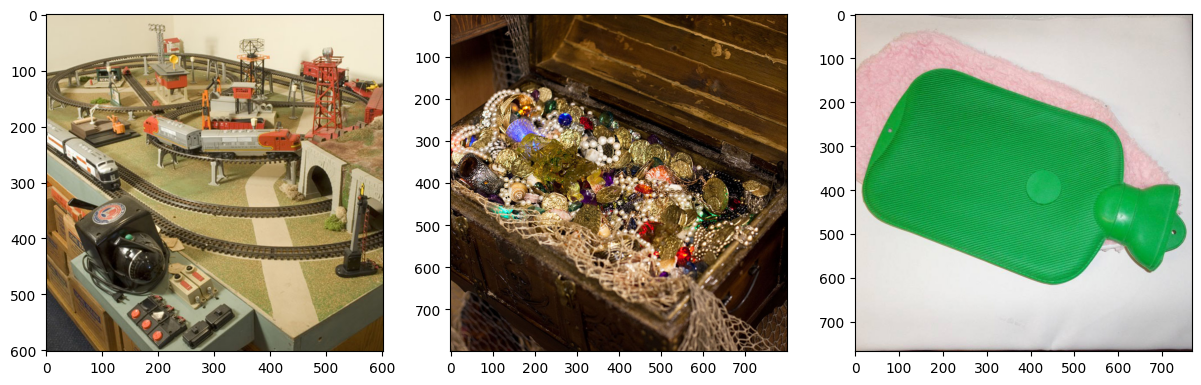

In [ ]:
# visualize triplet sample with image indices [1700, 1707, 804]
sample_set = train_triplet[5]
plt.figure(figsize=(20, 5))

for i in range(len(sample_set)):
  plt.subplot(1, 4, i + 1)
  filename = imagelist[int(sample_set[i])]
  print(filename)
  plt.imshow(np.array(Image.open('object_images/' + filename)))

## Training a Siamese Model

### Define the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Triplet(nn.Module):
  def __init__(self):
    super(Triplet,self).__init__()

    # get resnet model
    self.resnet = torchvision.models.resnet18(pretrained = True)
    self.fc_out_features = self.resnet.fc.out_features  # output feature of the resnet

    # add linear layer to compare between teh features of the three images

    self.fc = nn.Sequential(
             nn.Linear(self.fc_out_features*3,256),
             nn.ReLU(inplace=True),
             nn.Linear(256,3)
    )

    self.softmax = nn.Softmax()

    # initialize the weights
    self.resnet.apply(self.init_weights)
    self.fc.apply(self.init_weights)

  def init_weights(self,m):
    if isinstance(m,nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  def forward_once(self,x):
    output = self.resnet(x)
    output = output.view(output.size()[0],-1)
    return output

  def forward(self,input1,input2,input3):
    # get threee images' features
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    output3 = self.forward_once(input3)

    # concatenate the images' features
    output = torch.cat([output1,output2,output3],dim = 1)

    # pass the concatenation to the linear layers
    output = self.fc(output)

    # pass the out of the linear layers to sigmoid layer
    output = self.softmax(output)

    return output

### Data loading

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, image_matrix, triplets):
        """
        Args:
            image_matrix (numpy array): The matrix of images with shape (1854, 800, 800, 3).
            triplets (numpy array): The triplets of image indices with shape (n_triplets, 3).
        """
        self.image_matrix = image_matrix
        self.triplets = triplets
        self.imageTransform = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.Resize(256),
                                                  transforms.CenterCrop(224),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                       std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        idx_1, idx_2, idx_3 = self.triplets[idx]
        img_1 = self.image_matrix[idx_1]
        img_2 = self.image_matrix[idx_2]
        img_3 = self.image_matrix[idx_3]

        # Convert to torch tensors
        img_1 = torch.tensor(img_1, dtype=torch.float32).permute(2, 0, 1)  # (3, 800, 800)
        img_2 = torch.tensor(img_2, dtype=torch.float32).permute(2, 0, 1)
        img_3 = torch.tensor(img_3, dtype=torch.float32).permute(2, 0, 1)

        # Transform
        img_1 = self.imageTransform(img_1)
        img_2 = self.imageTransform(img_2)
        img_3 = self.imageTransform(img_3)

        # set the label
        target = torch.tensor([0,0,1], dtype=torch.float)

        # shuffle the index of odd image
        random_idx = torch.randperm(3)
        target= target[random_idx]
        image_temp = torch.concat([img_1.unsqueeze(0),img_2.unsqueeze(0),img_3.unsqueeze(0)],dim=0)
        img_1,img_2,img_3 = tuple([image_temp[x] for x in random_idx])

        return img_1, img_2, img_3, target


# Create datasets
train_dataset = TripletDataset(images_data, train_triplet)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Example of iterating through the training loader
for batch in train_loader:
    img_1, img_2, img_3,target = batch
    print(img_1.shape, img_2.shape, img_3.shape,target.shape,img_1.max(),img_1.min())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32, 3]) tensor(2.6400) tensor(-2.1179)


Model Training

In [ ]:
def train(model,device,train_loader,optimizer,epoch,dry_run=False):
  model.train() # switch to training mode
  criterion = nn.BCELoss()

  loss_list = []

  for batch_idx, (images_1,images_2,images_3,targets) in enumerate(train_loader):
    images_1,images_2,images_3,targets = images_1.to(device),images_2.to(device),images_3.to(device),targets.to(device)

    optimizer.zero_grad()
    outputs = model(images_1,images_2,images_3).squeeze()
    loss = criterion(outputs,targets) # need to check the dimensions

    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch,batch_idx*len(images_1),len(train_loader.dataset),
          100. * batch_idx / len(train_loader),loss.item()))
    if dry_run:
        break

    loss_list.append(loss.sum().item())


  return loss_list/len(train_loader.dataset)



### Model Testing

In [ ]:
def test(model,device,test_loader, return_loss = False):
  model.eval() # switch to testing  mode
  test_loss = 0
  correct =0

  criterion = nn.BCELoss()

  with torch.no_grad():
    for (images_1,images_2,images_3,targets) in test_loader:
      images_1,images_2,images_3,targets = images_1.to(device),images_2.to(device),images_3.to(device),targets.to(device)
      outputs = model(images_1,images_2,images_3).squeeze()
      test_loss += criterion(outputs,targets).sum().item() # sum up the loss in the batch
      pred = torch.zeros_like(outputs) # num_batch X 3, need to check
      pred[torch.argmax(outputs,dim=1)]=1 # NEED TO CHECK, set 1 at the index of  max probablity
      correct += pred.eq(targets.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
  # using default settings. After completing the 10th epoch, the average
  # loss is 0.0000 and the accuracy 99.5-100% using default settings.
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  return test_loss

In [ ]:
train_triplet.shape

(4120663, 3)

In [ ]:
device = torch.device("cuda")

# hyperparameters
lr = 0.01
gamma = 0.001
epoches = 10
batch_size = 32

# Define the training, testing, and validation datasets
train_subset = np.random.choice(np.arange(len(train_triplet)),50000)
valid_subset = np.random.choice(np.arange(len(validationset_triplet)),50000)

train_dataset = TripletDataset(images_data, train_triplet[train_subset])
test1_dataset = TripletDataset(images_data, testset1_triplet)
test2_dataset = TripletDataset(images_data, testset2rep_triplet)
test3_dataset = TripletDataset(images_data, testset3_triplet)
validation_dataset = TripletDataset(images_data, validationset_triplet[valid_subset])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test1_loader = DataLoader(test1_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test3_loader = DataLoader(test3_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


# define instance of the model class

model = Triplet().to(device)
optimizer = optim.Adadelta(model.parameters(),lr = lr)
scheduler = StepLR(optimizer,step_size=1,gamma= gamma)


In [ ]:
train_triplet.shape

(4120663, 3)

Do Training

Training the model:   0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.215423
Train Epoch: 1 [320/50000 (1%)]	Loss: 0.747615
Train Epoch: 1 [640/50000 (1%)]	Loss: 0.698961
Train Epoch: 1 [960/50000 (2%)]	Loss: 0.672417
Train Epoch: 1 [1280/50000 (3%)]	Loss: 0.688901
Train Epoch: 1 [1600/50000 (3%)]	Loss: 0.770626
Train Epoch: 1 [1920/50000 (4%)]	Loss: 0.707026
Train Epoch: 1 [2240/50000 (4%)]	Loss: 0.733500
Train Epoch: 1 [2560/50000 (5%)]	Loss: 0.677370
Train Epoch: 1 [2880/50000 (6%)]	Loss: 0.610828
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.658860
Train Epoch: 1 [3520/50000 (7%)]	Loss: 0.707457
Train Epoch: 1 [3840/50000 (8%)]	Loss: 0.705696
Train Epoch: 1 [4160/50000 (8%)]	Loss: 0.690822
Train Epoch: 1 [4480/50000 (9%)]	Loss: 0.640138
Train Epoch: 1 [4800/50000 (10%)]	Loss: 0.675319
Train Epoch: 1 [5120/50000 (10%)]	Loss: 0.742132
Train Epoch: 1 [5440/50000 (11%)]	Loss: 0.640723
Train Epoch: 1 [5760/50000 (12%)]	Loss: 0.677822
Train Epoch: 1 [6080/50000 (12%)]	Loss: 0.738180
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0

TypeError: unsupported operand type(s) for /: 'list' and 'int'

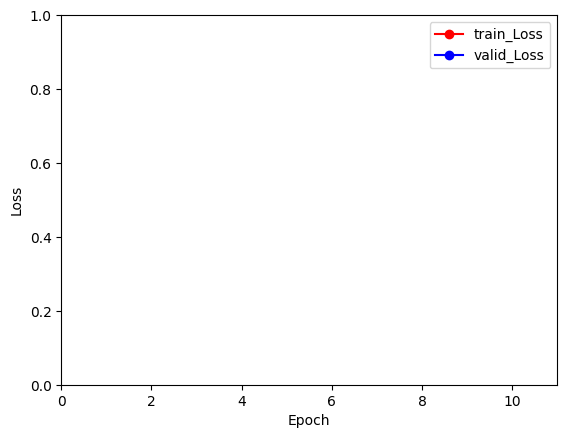

In [ ]:
dry_run = False
train_loss,valid_loss =  [],[]

# initialize the plot
plt.ion()  # Turn on interactive mode for real-time plotting
fig, ax = plt.subplots()
line_train, = ax.plot([],[], 'r-', marker='o', label='train_Loss')
line_valid, = ax.plot([],[], 'b-', marker='o', label='valid_Loss')

ax.set_xlim(0, epoches + 1)  # Set x-axis limits
ax.set_ylim(0, 1)  # Set y-axis limits, adjust based on your loss range
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

for epoch in tqdm(range(1,epoches+1),desc = 'Training the model'):
  curr_train_loss = train(model,device,train_loader,optimizer,epoch,dry_run = dry_run)
  train_loss.append(curr_train_loss)
  if dry_run:
    break
  curr_valid_loss = test(model,device,validation_loader)
  valid_loss.append(curr_valid_loss)
  scheduler.step()

  # plot loss
  line_train.set_xdata(np.arange(len(train_loss)))
  line_train.set_ydata(train_loss)

  line_valid.set_xdata(np.arange(len(valid_loss)))
  line_valid.set_ydata(valid_loss)

  ax.relim()
  ax.autoscale_view()
  plt.draw()
  plt.pause(0.1)  # Pause to update the plot


plt.ioff()  # Turn off interactive mode
plt.show()  # Show the plot after training

Test the model

In [ ]:

# run on test set
test1_loss = test(model,device,test1_loader,return_loss=True)
test2_loss = test(model,device,test2_loader,return_loss=True)
test3_loss = test(model,device,test3_loader,return_loss=True)